# FIG. 2. Daily vehicle usage in Germany based on the German Mobility Panel (MOP)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs

crs = ccrs.GOOGLE_MERCATOR
from datetime import timedelta
import seaborn as sns

labelsize = 24
pgf_with_latex = {  # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
    "text.usetex": True,  # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots
    "font.sans-serif": [],  # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": labelsize,  # LaTeX default is 10pt font.
    "font.size": labelsize,
    "legend.fontsize": labelsize,  # Make the legend/label fonts
    "xtick.labelsize": labelsize,  # a little smaller
    "ytick.labelsize": labelsize,
    "figure.figsize": (12, 8),  # default fig size of 0.9 textwidth
    "pgf.preamble": "\n".join(
        [  # plots will use this preamble
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[T1]{fontenc}",
        ]
    ),
}
mpl.rcParams.update(pgf_with_latex)

from src import GermanMobiltyPanel as gmp


### Some functions to compute the amount of vehicles on the roads

In [3]:
def convert_int_to_timedelta(number):
    if type(number) == int:
        strnumber = str(number)
        while len(strnumber) < 4:
            strnumber = "0" + strnumber
        return timedelta(hours=int(strnumber[0:2]), minutes=int(strnumber[2:4]))


def bin_drivers(W, bin_length=25):
    date = pd.to_timedelta(W["DATUM"], unit="D") + pd.Timestamp(
        year=1960, month=1, day=1, hour=0, minute=0
    )
    abzeit = [convert_int_to_timedelta(t) for t in W["ABZEIT"]]
    anzeit = [convert_int_to_timedelta(t) for t in W["ANZEIT"]]

    date_an = [date.iloc[i] + anzeit[i] for i in range(0, len(W))]
    date_ab = [date.iloc[i] + abzeit[i] for i in range(0, len(W))]
    W["dep_time"] = date_ab
    W["arr_time"] = date_an
    W["drive_time"] = W["arr_time"] - W["dep_time"]

    bins = np.linspace(0, 24, bin_length)
    dep_labels = np.linspace(0, 23, bin_length - 1)
    arr_labels = np.linspace(1, 24, bin_length - 1)
    dep_bins = pd.cut(W["dep_time"].dt.hour, bins, right=False, labels=dep_labels)
    arr_bins = pd.cut(W["arr_time"].dt.hour, bins, right=False, labels=arr_labels)

    W["dep_bins"] = dep_bins
    W["arr_bins"] = arr_bins
    return W


def drivers_on_road(W):
    W = bin_drivers(W)
    # arr_bins = pd.cut(W['arr_time'].dt.hour, bins, right=False, labels=arr_labels)

    arrivals = W[["arr_bins", "ID"]].groupby(["arr_bins"]).count().values
    dests = W[["ID", "dep_bins"]].groupby(["dep_bins"]).count().values
    drivers_on_road = (dests + arrivals) / 2

    dep_arr_table = W.pivot_table(
        index=W["arr_bins"],
        columns="dep_bins",
        values="ID",
        aggfunc="count",
        fill_value=0,
    )
    dep_arr_table

    return drivers_on_road.reshape(24), dep_arr_table


def drivers_on_road_per_day(W):
    W = bin_drivers(W)

    driver_d = np.array([])

    for date in W["DATUM"].unique():
        WD = W[W["DATUM"] == date]
        arr = WD[["arr_bins", "ID"]].groupby(["arr_bins"]).count().values
        dsts = WD[["ID", "dep_bins"]].groupby(["dep_bins"]).count().values
        drivers_on_road_d = ((dsts + arr) / 2).reshape(24)
        driver_d = np.append(driver_d, drivers_on_road_d / sum(drivers_on_road_d))

    driver_d = driver_d.reshape(len(W["DATUM"].unique()), 24)
    return driver_d


### Read date of the MOP (Skipping 2003, because of bad data) and compute hourly drivers on roads

In [5]:
years = range(1995, 2020)

W = gmp.read_W(1994)
driver_d_y = drivers_on_road_per_day(W)
for year in years:
    if year != 2003:
        W = gmp.read_W(year)
        driver_d = drivers_on_road_per_day(W)
        driver_d_y = np.vstack((driver_d_y, driver_d))

days = np.linspace(0, 24, 25)
std = np.std(driver_d_y, axis=0)
std = np.insert(std, 0, std[-1])
drivers = np.mean(driver_d_y, axis=0)
drivers = np.insert(drivers, 0, drivers[-1])


### Create pivot table of weekly drivers distribution

In [6]:
###############################################
dep_week = W.pivot_table(
    index=W["dep_bins"], columns="WOTAG", values="ID", aggfunc="count", fill_value=0
)
arr_week = W.pivot_table(
    index=W["arr_bins"], columns="WOTAG", values="ID", aggfunc="count", fill_value=0
)
week_data = (arr_week.values + dep_week.values) / 2


### Count amount of people who use a car per day

In [7]:
years = range(1999, 2020)
wotag_df = pd.DataFrame()
for year in years:
    PT = gmp.read_PT(year)
    PT0 = PT[PT["AnzPKW"] == 0]
    PT1 = PT[PT["AnzPKW"] > 0]

    wotag_df[year] = (
        PT1[["WOTAG", "ID"]].groupby(["WOTAG"]).count()
        / PT[["WOTAG", "ID"]].groupby(["WOTAG"]).count()
    )

days = np.linspace(1, 7, 7)
std = wotag_df.std(axis=1)
drivers_frac = wotag_df.mean(axis=1)


### For 2020 compare the vehicle usage with respect to the population density

In [9]:
PT = gmp.read_PT(2020)
PT0 = PT[PT["AnzPKW"] == 0]
PT1 = PT[PT["AnzPKW"] > 0]

siedd_frac = (
    PT1[["SIEDDICHTE", "ID"]].groupby(["SIEDDICHTE"]).count()
    / PT[["SIEDDICHTE", "ID"]].groupby(["SIEDDICHTE"]).count()
)

week_dichte = (
    PT1[["SIEDDICHTE", "WOTAG", "ID"]].groupby(["SIEDDICHTE", "WOTAG"]).count()
    / PT[["SIEDDICHTE", "WOTAG", "ID"]].groupby(["SIEDDICHTE", "WOTAG"]).count()
).unstack(fill_value=0)


### Create Figure

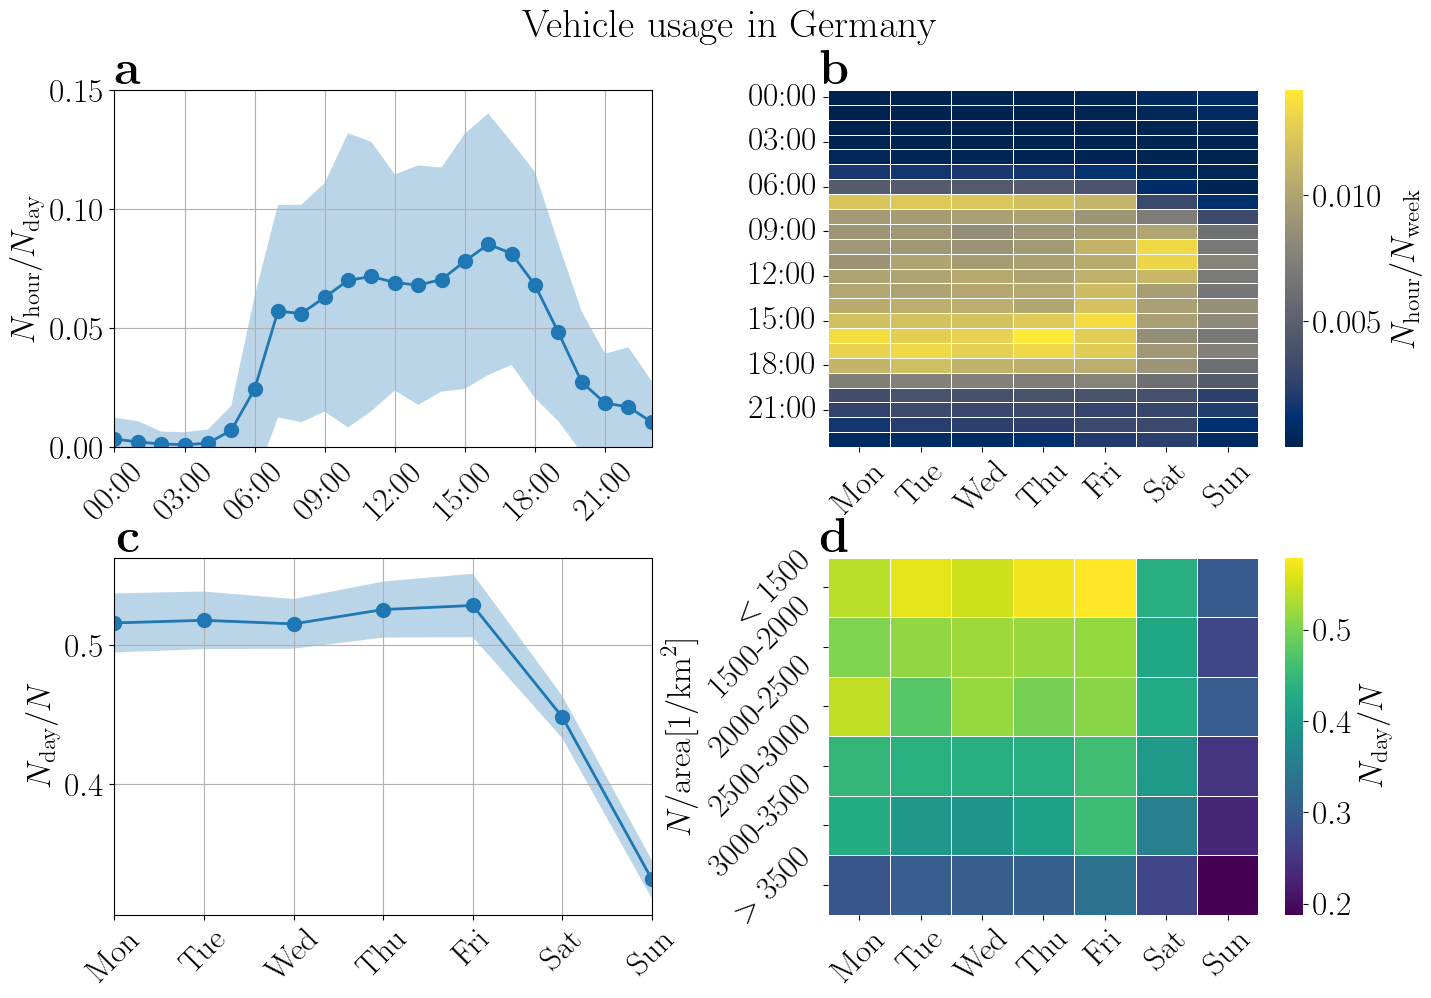

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.tight_layout(w_pad=3, h_pad=2)
# fig.tight_layout(h_pad=2)
fig.suptitle("Vehicle usage in Germany")
plt.subplots_adjust(top=0.9)


labels = [r"\textbf{a}", r"\textbf{b}", r"\textbf{c}", r"\textbf{d}"]
for i, ax in enumerate(axs.reshape(4)):
    ax.grid()
    ax.text(
        0.05,
        1.11,
        labels[i],
        transform=ax.transAxes,
        fontweight="bold",
        fontsize=35,
        va="top",
        ha="right",
    )


ax0 = axs[0, 0]

days = np.linspace(0, 23, 24)
std = np.std(driver_d_y, axis=0)
# std = np.insert(std, 0, std[-1])
drivers = np.mean(driver_d_y, axis=0)
# drivers = np.insert(drivers, 0, drivers[-1])

ax0.plot(days, drivers, marker="o", linewidth=2, markersize=10)
ax0.fill_between(days, drivers + std, drivers - std, alpha=0.3)
ax0.xaxis.set_ticks([0, 3, 6, 9, 12, 15, 18, 21])
time_ticks_labels = [
    "00:00",
    "03:00",
    "06:00",
    "09:00",
    "12:00",
    "15:00",
    "18:00",
    "21:00",
]
ax0.set_xticklabels(time_ticks_labels, rotation=45)
ax0.set_ylabel(r"$N_{\mathrm{hour}}/N_{\mathrm{day}}$")
ax0.set_ylim([0, 0.15])
ax0.set_xlim([0, 23])

days = np.linspace(1, 7, 7)
std = wotag_df.std(axis=1)
drivers_frac = wotag_df.mean(axis=1)

ax1 = axs[1, 0]
ax1.plot(drivers_frac, marker="o", linewidth=2, markersize=10)
ax1.fill_between(days, drivers_frac + std, drivers_frac - std, alpha=0.3)
ax1.set_ylabel(r"$N_{\mathrm{day}}/N$")
ax1.xaxis.set_ticks([1, 2, 3, 4, 5, 6, 7])
x_ticks_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ax1.set_xticklabels(x_ticks_labels, rotation=45)
ax1.set_xlim([1, 7])


ax3 = axs[0, 1]
sns.heatmap(
    week_data / week_data.sum(),
    fmt="d",
    linewidths=0.5,
    ax=ax3,
    cmap="cividis",
    cbar_kws={"label": r"$N_{\mathrm{hour}}/N_{\mathrm{week}}$"},
)
x_ticks_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ax3.yaxis.set_ticks(np.array([0, 3, 6, 9, 12, 15, 18, 21]) + 0.5)
ax3.set_yticklabels(time_ticks_labels, rotation="horizontal")
ax3.set_xticklabels(x_ticks_labels, rotation=45)
ax3.grid()


ax2 = axs[1, 1]
sns.heatmap(
    week_dichte.to_numpy(),
    ax=ax2,
    fmt="d",
    linewidths=0.5,
    cmap="viridis",
    cbar_kws={"label": r"$N_{\mathrm{day}}/N$"},
)
x_ticks_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ax2.set_xticklabels(x_ticks_labels, rotation=45)
y_ticks_labels = [
    r"$<1500$",
    "1500-2000",
    "2000-2500",
    "2500-3000",
    "3000-3500",
    r"$>3500$",
]
ax2.set_yticklabels(y_ticks_labels, rotation=45)
ax2.set_ylabel(r"$N/\mathrm{area} [1/\mathrm{km}^2]$")
ax2.grid()
# ax.set_xlabel("Weekday")


In [15]:
fig.savefig("results/figs/FIG2-MOP.pdf", bbox_inches="tight")


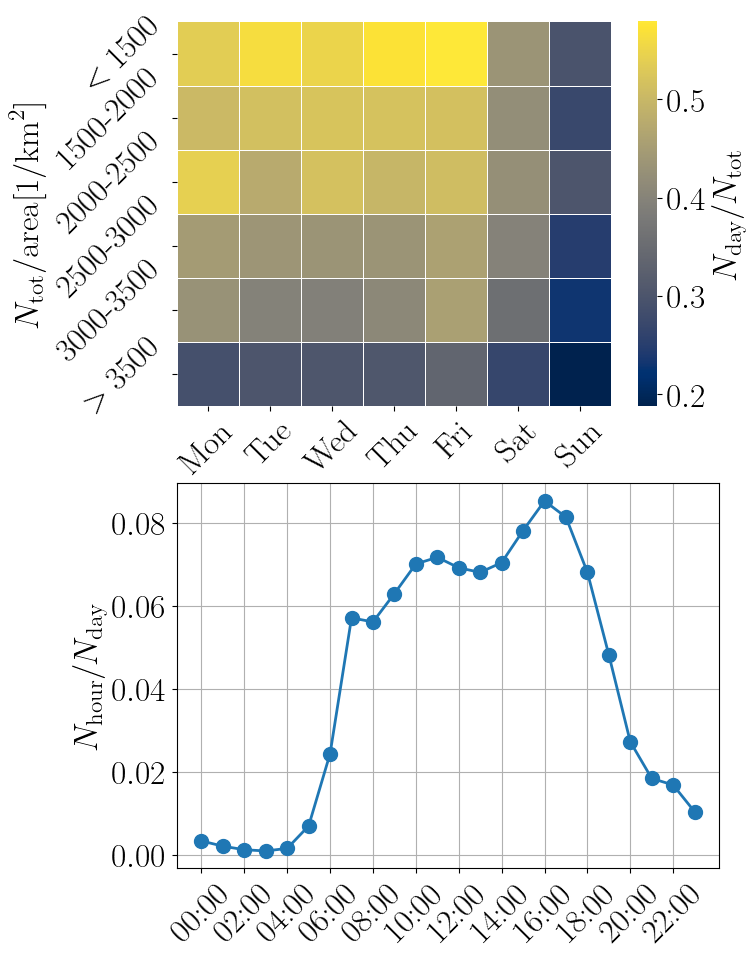

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(7, 11))

ax0 = axs[0]
sns.heatmap(
    week_dichte.to_numpy(),
    ax=ax0,
    fmt="d",
    linewidths=0.5,
    cmap="cividis",
    cbar_kws={"label": r"$N_{\mathrm{day}}/N_\mathrm{tot}$"},
)
x_ticks_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ax0.set_xticklabels(x_ticks_labels, rotation=45)
y_ticks_labels = [
    r"$<1500$",
    "1500-2000",
    "2000-2500",
    "2500-3000",
    "3000-3500",
    r"$>3500$",
]
ax0.set_yticklabels(y_ticks_labels, rotation=45)
ax0.set_ylabel(r"$N_{\mathrm{tot}}/\mathrm{area} [1/\mathrm{km}^2]$")


ax1 = axs[1]
ax1.plot(
    np.linspace(0, 23, 24),
    drivers / drivers.sum(),
    marker="o",
    linewidth=2,
    markersize=10,
)
ax1.xaxis.set_ticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22])
time_ticks_labels = [
    "00:00",
    "02:00",
    "04:00",
    "06:00",
    "08:00",
    "10:00",
    "12:00",
    "14:00",
    "16:00",
    "18:00",
    "20:00",
    "22:00",
]
ax1.set_xticklabels(time_ticks_labels, rotation=45)
ax1.set_ylabel(r"$N_{\mathrm{hour}}/N_{\mathrm{day}}$")
ax1.grid()
